<h1 style="text-align: center;">Temperature Forecast for alloy at Steel Plant "Steel Bird"</h1>

To optimize production costs, the metallurgical plant "Steel Bird" decided to reduce electricity consumption during the steel processing stage. To achieve this, the plant needs to control the alloy temperature. Your task is to build a model that predicts it. 
The client wants to use the developed model for simulating the technological process. 

The technological process is as follows (useful for evaluating feature generation):

Steel is processed in a metal ladle with a capacity of about 100 tons. To withstand high temperatures, the inside of the ladle is lined with refractory bricks. Molten steel is poured into the ladle and heated to the desired temperature using graphite electrodes mounted in the lid.

Sulfur is removed from the alloy (this process is called desulfurization), impurities are added to adjust the chemical composition, and samples are taken. The steel is alloyed—its composition is altered—by introducing pieces of alloy from a bulk material bunker or wire through a special trib-apparatus (from English “tribe” meaning “mass”).

Before the alloying materials are introduced for the first time, the steel temperature is measured, and a chemical analysis is performed. Then, the temperature is increased for a few minutes, alloying materials are added, and the alloy is blown with inert gas. The mixture is stirred, and measurements are taken again. This cycle is repeated until the target chemical composition and optimal melting temperature are achieved.

The molten steel is then sent for final processing or to a continuous casting machine, where the final product emerges in the form of slabs.

**Data Description**
The data consists of several files obtained from different sources:
•	data_arc_new.csv — data about electrodes;
•	data_bulk_new.csv — data on bulk material input (volume);
•	data_bulk_time_new.csv — data on bulk material input (time);
•	data_gas_new.csv — data on alloy gas blowing;
•	data_temp_new.csv — temperature measurement results;
•	data_wire_new.csv — data on wire materials (volume);
•	data_wire_time_new.csv — data on wire materials (time).

**Target Feature** — the alloy temperature, represented by the column temperature in the table data_temp_new.csv.  
**Target Metric** — MAE (Mean Absolute Error), not exceeding 6.8 degrees.

<a id='To-contents'></a>

**Project Contents**   
[Data Loading](#Data-Loading) \
[Exploratory Data Analysis and Data Preprocessing](#Exploratory-Data-Analysis-and-Data-Preprocessing) \
[Data Merging](#Data-Merging) \
[Exploratory Data Analysis and Data Preprocessing of the Merged DataFrame](#Exploratory-Data-Analysis-and-Data-Preprocessing-of-the-Merged-DataFrame) \
[Data Preparation and Model Training](#Model-Training) \
[Analysis and Testing of the Final Model](#Analysis-and-Testing-of-the-Final-Model) \
[General Conclusion](#General-Conclusion)


In [1]:
%%capture
!pip install tensorflow
!pip install scikeras
!pip install catboost

In [2]:
# importing libraries before starting the project in one block
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from tqdm.notebook import tqdm

# loading the pipeline class
from sklearn.pipeline import Pipeline

# loading classes for data preparation
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# importing GridSearchCV classes
from sklearn.model_selection import GridSearchCV

# loading necessary models
from sklearn.linear_model import LinearRegression, ElasticNet
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# loading modules for the neural networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Input
from scikeras.wrappers import KerasRegressor

# loading functions for working with metrics
from sklearn.metrics import mean_absolute_error


2024-10-08 12:53:16.870388: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 12:53:16.872768: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-08 12:53:16.878718: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-08 12:53:16.893977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 12:53:16.916669: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [3]:
# extracting the block with settings and functions

# setting DataFrame display options before loading
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# displaying information about the structure and data of each DataFrame
def get_info(dataset):
    dataset.info()
    display(dataset.head(5))
    display(dataset.tail(5))

# displaying histogram and boxplot
def hist_box(data,column,hue=None, bins=100,m=10,n=3):
    
    palette = sns.color_palette('hsv', n_colors=10)
    random_color = random.choice(palette)
    
    if hue == None:
        
        fig, axes = plt.subplots(1, 2, figsize=(m, n)) 
        ax = axes[0]
        sns.histplot(data=data, x=column, bins=bins, 
                     color=random_color,
                     alpha=0.6,
                     legend='auto', ax=ax)
    else:
        fig, axes = plt.subplots(1, 2, figsize=(m, n)) 
        ax = axes[0]
        sns.histplot(data=data, x=column, bins=bins, 
                     color=random_color,
                     alpha=0.6,
                     hue=hue, 
                     multiple='stack',
                     legend='auto', ax=ax)
        

    ax = axes[1]
    sns.boxplot(x=data[column], color=random_color, ax=ax)
    ax.set_ylabel('')

    plt.tight_layout()
    plt.show();

<a id='Data-Loading'></a> 
## Data Loading
[To Contents](#To-contents)

In [4]:
# importing data
pth1 = ['/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_15_Metal(final)/data_arc_new.csv',
        '/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_15_Metal(final)/data_bulk_new.csv',
        '/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_15_Metal(final)/data_bulk_time_new.csv',
        '/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_15_Metal(final)/data_gas_new.csv',
        '/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_15_Metal(final)/data_temp_new.csv',
        '/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_15_Metal(final)/data_wire_new.csv',
        '/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_15_Metal(final)/data_wire_time_new.csv']

pth2 = ['/datasets/data_arc_new.csv',
        '/datasets/data_bulk_new.csv',
        '/datasets/data_bulk_time_new.csv',
        '/datasets/data_gas_new.csv',
        '/datasets/data_temp_new.csv',
        '/datasets/data_wire_new.csv',
        '/datasets/data_wire_time_new.csv']

tables = ['arc_df','bulk_df','bulk_time_df','gas_df','temp_df','wire_df','wire_time_df'] 

for i in range(len(tables)):
    if os.path.exists(pth1[i]):
        globals()[tables[i]] = pd.read_csv(pth1[i])
    elif os.path.exists(pth2[i]):
        globals()[tables[i]] = pd.read_csv(pth2[i])
    else:
        print(f'Файл {pth1[i]} или {pth2[i]} не найден')

In [5]:
for name in tables:
    display(Markdown(f'**Data and examples for the table {name}:**\n'))
    get_info(globals()[name])

**Данные и примеры для таблицы arc_df:**


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347


**Данные и примеры для таблицы bulk_df:**


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


**Данные и примеры для таблицы bulk_time_df:**


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,2019-09-06 11:54:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 11:49:45,NaN,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaN,NaN,2019-09-06 12:26:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 12:18:35,NaN,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 17:26:33,2019-09-06 17:23:15


**Данные и примеры для таблицы gas_df:**


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


**Данные и примеры для таблицы temp_df:**


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


,key,Время замера,Температура
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN
18091,3241,2019-09-06 17:30:05,NaN


**Данные и примеры для таблицы wire_df:**


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Данные и примеры для таблицы wire_time_df:**


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-06 17:10:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Conclusion**

When loading the data, several points can be noted right away:
- There are quite a few missing values, but they are likely due to the fact that certain materials were intentionally not added during the processing of certain metal batches. Therefore, these missing values should be filled with zeros or categorical labels indicating the absence;
- The data types of the timestamps are inconsistent and need to be converted to date format;
- The data should be checked for duplicates;
- The target feature has many missing values (around 15%), and these data points should be excluded from the target feature sample and the corresponding input feature values, as there is no point in using input features from a batch if we don’t have temperature data for that batch;
- The features obtained after measuring the temperature should also be checked, as they are useless for preliminary forecasting (if certain elements are added after the temperature measurement);
- It is important to check the data for outliers and anomalies and examine the distribution of feature values;
- The column names in the tables are informative but inconvenient for usage—later, when merging the features into a single table, the columns will need to be renamed.

<a id='Exploratory-Data-Analysis-and-Data-Preprocessing'></a> 
## Exploratory Data Analysis and Data Preprocessing
[To Contents](#To-contents)

First, we will preprocess the data, taking into account the observations from the conclusions in the previous section.

In [6]:
# convert the time data to the correct datetime type
arc_df['Начало нагрева дугой'] = pd.to_datetime(arc_df['Начало нагрева дугой'])
arc_df['Конец нагрева дугой'] = pd.to_datetime(arc_df['Конец нагрева дугой'])

for i in range(1,16):
    bulk_time_df['Bulk '+str(i)] = pd.to_datetime(bulk_time_df['Bulk '+str(i)])

temp_df['Время замера'] = pd.to_datetime(temp_df['Время замера'])

for i in range(1,10):
    wire_time_df['Wire '+str(i)] = pd.to_datetime(wire_time_df['Wire '+str(i)])


In [7]:
# check for duplicates before merging
for name in tables:
    print(f'Количество дубликатов в таблице {name}: {globals()[name].duplicated().sum()}')
    

Количество дубликатов в таблице arc_df: 0
Количество дубликатов в таблице bulk_df: 0
Количество дубликатов в таблице bulk_time_df: 0
Количество дубликатов в таблице gas_df: 0
Количество дубликатов в таблице temp_df: 0
Количество дубликатов в таблице wire_df: 0
Количество дубликатов в таблице wire_time_df: 0


In [8]:
# check for missing values before merging
for name in tables:
    print(f'Количество пропусков в таблице {name}: {globals()[name].isna().sum().sum()}')


Количество пропусков в таблице arc_df: 0
Количество пропусков в таблице bulk_df: 35776
Количество пропусков в таблице bulk_time_df: 35776
Количество пропусков в таблице gas_df: 0
Количество пропусков в таблице temp_df: 3427
Количество пропусков в таблице wire_df: 23385
Количество пропусков в таблице wire_time_df: 23385


First, we will process the values of the target feature:  
- We will exclude batches where the temperature significantly dropped below 1500 degrees at any measurement point (the physical melting point of iron is 1538, but considering measurement errors, we will set the threshold at less than 1500), which indicates that the alloy's structure underwent critical changes;
- We will parse the table with temperatures for each batch to extract the alloy's temperature at the beginning and end of the stage and exclude batches that lack a final temperature (the target feature);
- Later, we will use the initial and final temperature measurement times to filter out batches where there was a violation of the technological process (additives were made outside the temperature measurement range).

In [9]:
# let's check how many measurements have critically low temperatures
temp_df[temp_df['Температура'] < 1500]

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


In [10]:
# select batches with temperatures below 1500
keys_to_delete = temp_df[temp_df['Температура'] < 1500]['key'].values
# remove these batches from the dataframe
temp_df = temp_df[~temp_df['key'].isin(keys_to_delete)]

In [11]:
# parse the temperature measurement table into the first measurement (+ measurement time) and the last measurement (+ measurement time, target feature)  
temp_keys = temp_df['key'].unique()
temp_clean = pd.DataFrame(columns=['key', 'start_temp_time','start_temp', 'end_temp_time', 'end_temp'])

for key in temp_keys:
    # filter the data by key and sort by measurement time
    key_temp_data = temp_df[temp_df['key'] == key].sort_values(by='Время замера')
    
    # create a new row with the necessary data
    new_row = pd.DataFrame({
        'key': [key], 
        'start_temp_time': [key_temp_data['Время замера'].iloc[0]], 
        'start_temp': [key_temp_data['Температура'].iloc[0]],
        'end_temp_time': [key_temp_data['Время замера'].iloc[-1]], 
        'end_temp': [key_temp_data['Температура'].iloc[-1]]
    })
    
    # add this row to a new dataframe with the time
    temp_clean = pd.concat([temp_clean, new_row], ignore_index=True)

temp_clean.head()

,key,start_temp_time,start_temp,end_temp_time,end_temp
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0


In [12]:
# count the batches that lack a final temperature (target feature values)
display(temp_clean[temp_clean['end_temp'].isna()].count())

# remove batches that lack a final temperature (target feature values)
temp_clean = temp_clean[~temp_clean['end_temp'].isna()]
temp_clean.info()

key                738
start_temp_time    738
start_temp         738
end_temp_time      738
end_temp             0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 0 to 2472
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   key              2473 non-null   object        
 1   start_temp_time  2473 non-null   datetime64[ns]
 2   start_temp       2473 non-null   float64       
 3   end_temp_time    2473 non-null   datetime64[ns]
 4   end_temp         2473 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(1)
memory usage: 115.9+ KB


In [13]:
# in the columns for the addition of bulk and wire additives, replace all NaN values with 0 
# and date/time values with 2019-05-01 (close to the start date of the experiment)
bulk_df.fillna(0, inplace=True)
bulk_time_df.fillna(pd.to_datetime('2019-05-01'), inplace=True)

wire_df.fillna(0, inplace=True)
wire_time_df.fillna(pd.to_datetime('2019-05-01'), inplace=True)


In [14]:
# convert column names to lowercase and replace spaces with underscores
for name in tables:
    df = globals()[name] 
    df.rename(columns={col: col.lower().replace(' ', '_') for col in df.columns}, inplace=True)


Next, we will examine outliers and data distributions across all tables using boxplot and histogram graphs.

In [15]:
# count the number of days in the arc power application table
print('Number of days the arc heating started: ', arc_df['начало_нагрева_дугой'].apply(lambda x: x.date()).nunique())
print('Number of days the arc heating ended: ', arc_df['конец_нагрева_дугой'].apply(lambda x: x.date()).nunique())


Количество дней начала нагрева дугой:  123
Количество дней конца нагрева дугой:  123


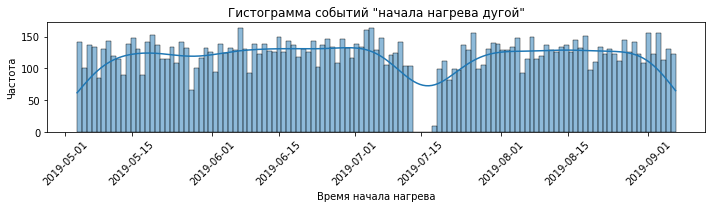

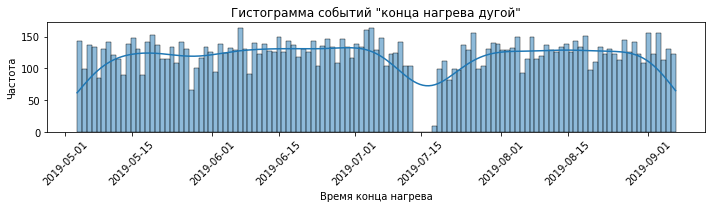

In [16]:
# plot the distributions of the "arc heating start" and "arc heating end" events by day

plt.figure(figsize=(10, 3))
sns.histplot(arc_df['начало_нагрева_дугой'], bins=123, kde=True)
plt.title('Histogram of "arc heating start" events')
plt.xlabel('Heating Start Time')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()

plt.figure(figsize=(10, 3))
sns.histplot(arc_df['конец_нагрева_дугой'], bins=123, kde=True)
plt.title('Histogram of "arc heating end" events')
plt.xlabel('Heating End Time')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

**Распределение активной мощности:**

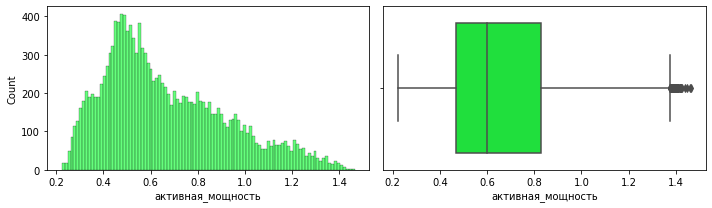

**Распределение активной мощности c группировкой по партиям:**

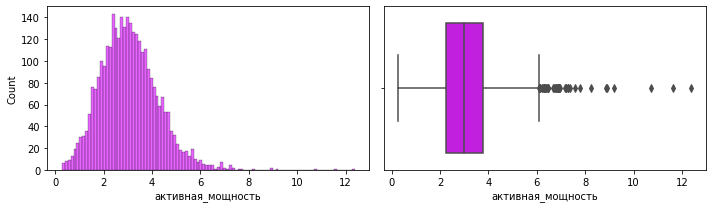

In [17]:
# plot histogram and boxplot graphs for active and reactive power values

display(Markdown('**Distribution of Active Power:**'))
hist_box(arc_df,'активная_мощность')  

display(Markdown('**Distribution of Active Power with Grouping by Batches:**'))
active_power = pd.DataFrame(arc_df.groupby('key')['активная_мощность'].sum())
hist_box(active_power, 'активная_мощность')

**Распределение реактивной мощности:**

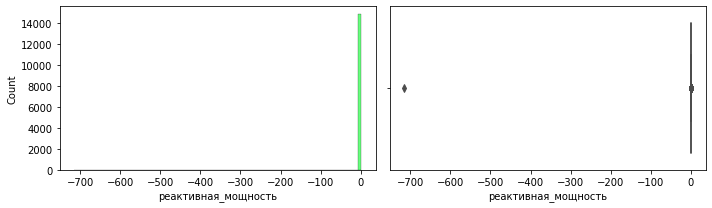

In [18]:
display(Markdown('**Distribution of Reactive Power:**'))
hist_box(arc_df,'реактивная_мощность')  

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


**Распределение реактивной мощности:**

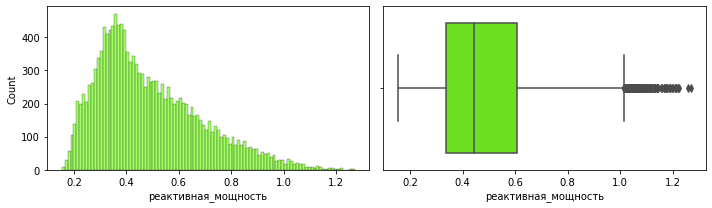

**Распределение реактивной мощности c группировкой по партиям:**

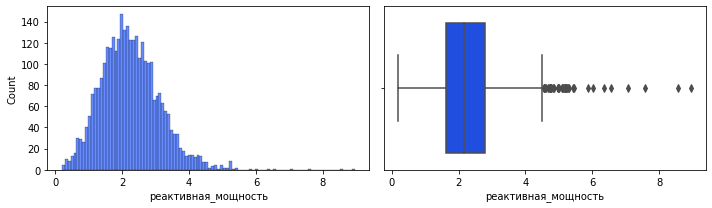

In [19]:
# we immediately see an anomaly in the negative direction
display(arc_df[arc_df['реактивная_мощность'] <0])

# one might assume that the data precision is incorrect, but even when reducing the value by a factor of 1000, the reactive power value will still be higher than the active power value, which is incorrect. Therefore, we will simply remove the row with this value.
arc_df = arc_df[arc_df['реактивная_мощность'] >=0]

# and let's check the distributions again
display(Markdown('**Распределение реактивной мощности:**'))
hist_box(arc_df,'реактивная_мощность')  

display(Markdown('**Распределение реактивной мощности c группировкой по партиям:**'))
active_power = pd.DataFrame(arc_df.groupby('key')['реактивная_мощность'].sum())
hist_box(active_power, 'реактивная_мощность')

From the power distribution graphs, we see the absence of anomalies (considering the single removed incorrect value) and a negligible number of outliers—most likely due to the technological process and not errors. Excluding them could negatively affect the model's generalization capability.

The distribution of the measurements themselves is quite uniform, with some seasonality (for example, on weekends), and there is a gap of several days in the middle of the range, which may be due to technical work.

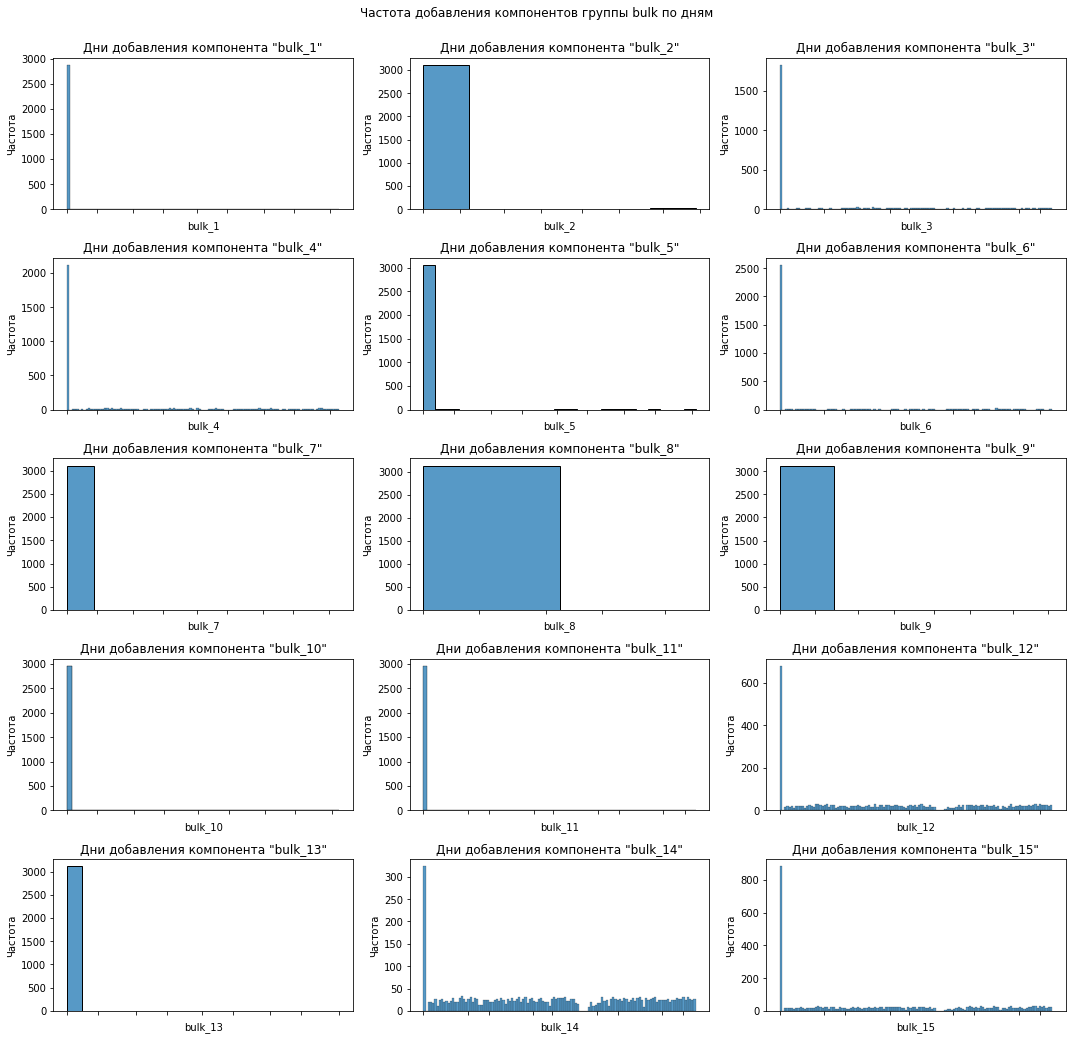

In [20]:
# in a similar manner, let's examine the distributions of the added components bulk and bulk_time

bulk_time_columns = bulk_time_df.columns[1:]

fig, axes = plt.subplots(5, 3, figsize=(15, 15))  # 5 строк и 3 столбца субплотов
fig.suptitle('Частота добавления компонентов группы bulk по дням', y=0.96)

for i, column in enumerate(bulk_time_columns):
    
    bins = bulk_time_df[column].apply(lambda x: x.date()).nunique()
    
    row = i // 3 
    col = i % 3  
    
    ax = axes[row, col]
    sns.histplot(bulk_time_df[column], bins=bins, ax=ax)
    ax.set_title(f'Days of Adding Component "{column}"')
    ax.set_ylabel('Frequency')
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45) 

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()


<h4 style="text-align: center;">Распределения добавок компонентов группы bulk в массо-объемных показателях</h4>

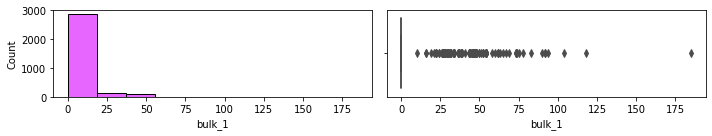

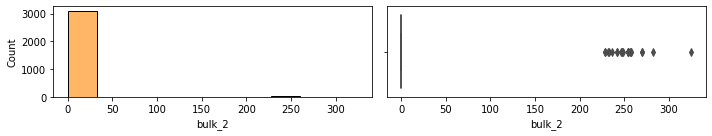

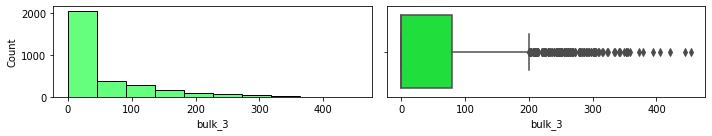

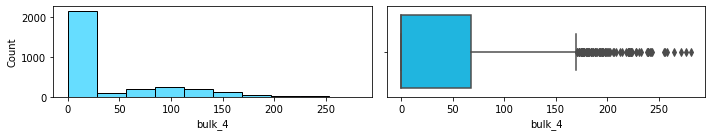

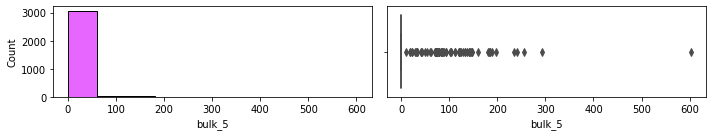

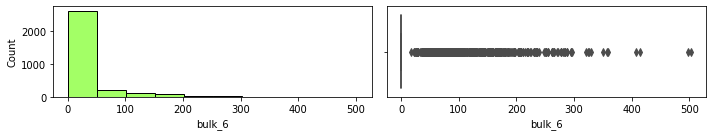

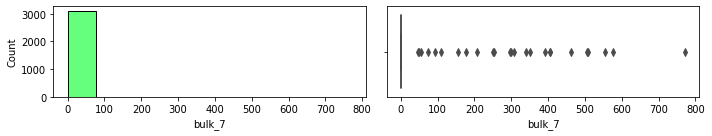

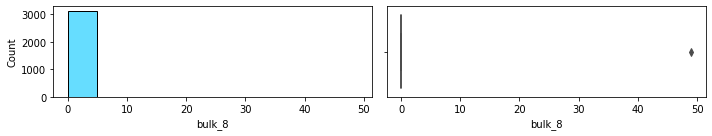

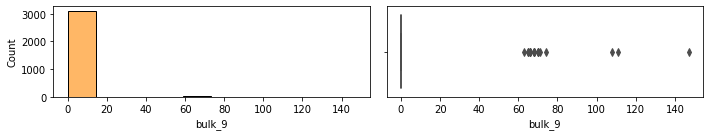

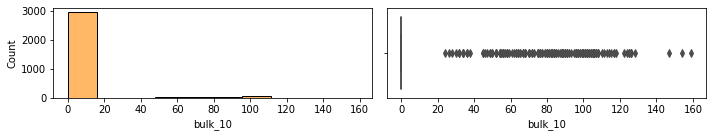

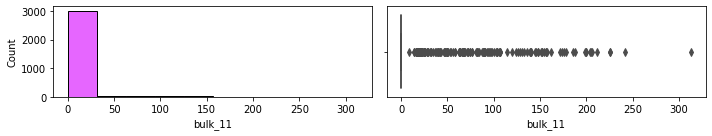

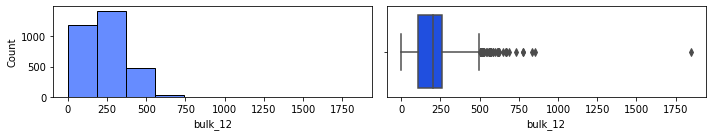

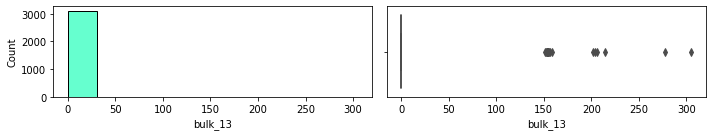

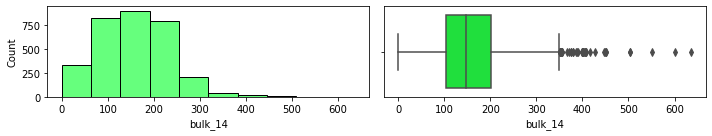

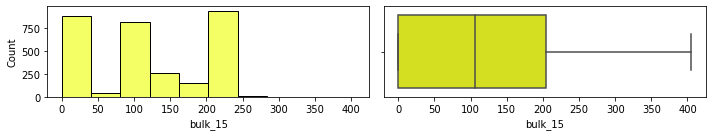

In [21]:
# let's take a look at the distribution of data on component additives
display(Markdown('<h4 style="text-align: center;">Distributions of bulk group additives in mass-volume indicators</h4>'))

bulk_columns = bulk_df.columns[1:]
for column in bulk_columns:
        hist_box(bulk_df,column,bins=10,n=2)

From the graphs of the bulk group additive data, it is evident that the most frequently used components are bulk_12, bulk_14, and bulk_15, which were added to almost every batch, while the least common are bulk_2, bulk_5, bulk_7, bulk_8, bulk_9, and bulk_13, which were added fewer than 100 times throughout the entire period.

In terms of volume, the same components lead, while the volumes of other additives tend to show a more discrete distribution for specific batches, possibly due to the technological process (to eliminate specific defects or to impart specific properties at the request of customers).

No anomalies were detected; all outliers in the boxplots are due to the presence of zero usage of a component in a batch—against the backdrop of zero usage, all discrete applications appear as outliers.

Статистики по значениям применения газа:

 count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: газ_1, dtype: float64 



<h4 style="text-align: center;">Распределения суммарных объемов газа для продувки сплава</h4>

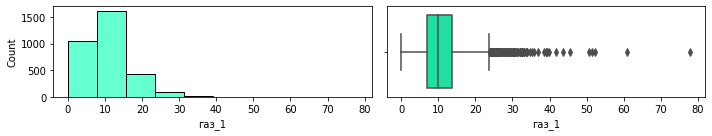

In [22]:
# let's take a look at the distribution of gas volume values
print('Statistics on gas usage values:\n\n', gas_df['газ_1'].describe(),'\n')

display(Markdown('<h4 style="text-align: center;">Distributions of total gas volumes for alloy blowing</h4>'))

hist_box(gas_df,'газ_1',bins=10,n=2)

Статистики по замерам входной температуры:

 count    2473.000000
mean     1589.016175
std        24.996127
min      1519.000000
25%      1572.000000
50%      1588.000000
75%      1605.000000
max      1679.000000
Name: start_temp, dtype: float64 

Статистики по замерам выходной температуры:

 count    2473.000000
mean     1595.338051
std        16.031388
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1599.000000
max      1700.000000
Name: end_temp, dtype: float64


<h4 style="text-align: center;">Распределение значений температур</h4>

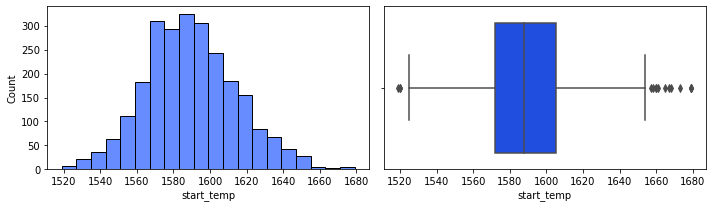

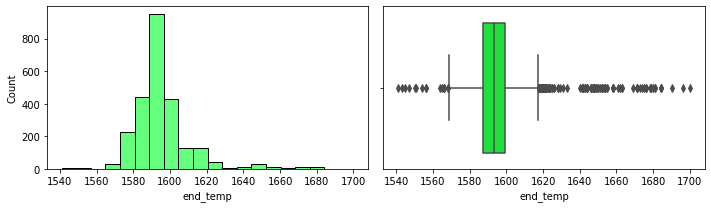

In [23]:
# let's take a look at the distribution of temperature measurement data based on the previously prepared table

print('Statistics on input temperature measurements:\n\n', temp_clean['start_temp'].describe(),'\n')
print('Statistics on output temperature measurements:\n\n',temp_clean['end_temp'].describe())

display(Markdown('<h4 style="text-align: center;">Distribution of temperature values</h4>'))

hist_box(temp_clean,'start_temp', bins=20)
hist_box(temp_clean,'end_temp',bins=20)


Gas blowing was not used in one-third of the cases, and gas is most often applied in minimal volumes.

The measurements of the incoming alloy temperature are distributed close to normal, with no significant outliers. In contrast, the output temperatures are distributed more closely to a T-distribution, showing a range toward higher values. This suggests the possibility of studying and reducing the output temperature (it is unlikely that an alloy with a higher temperature than what the technological process requires and the average temperature of most batches is needed at the output).

In [24]:
wire_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3081 non-null   datetime64[ns]
 2   wire_2  3081 non-null   datetime64[ns]
 3   wire_3  3081 non-null   datetime64[ns]
 4   wire_4  3081 non-null   datetime64[ns]
 5   wire_5  3081 non-null   datetime64[ns]
 6   wire_6  3081 non-null   datetime64[ns]
 7   wire_7  3081 non-null   datetime64[ns]
 8   wire_8  3081 non-null   datetime64[ns]
 9   wire_9  3081 non-null   datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


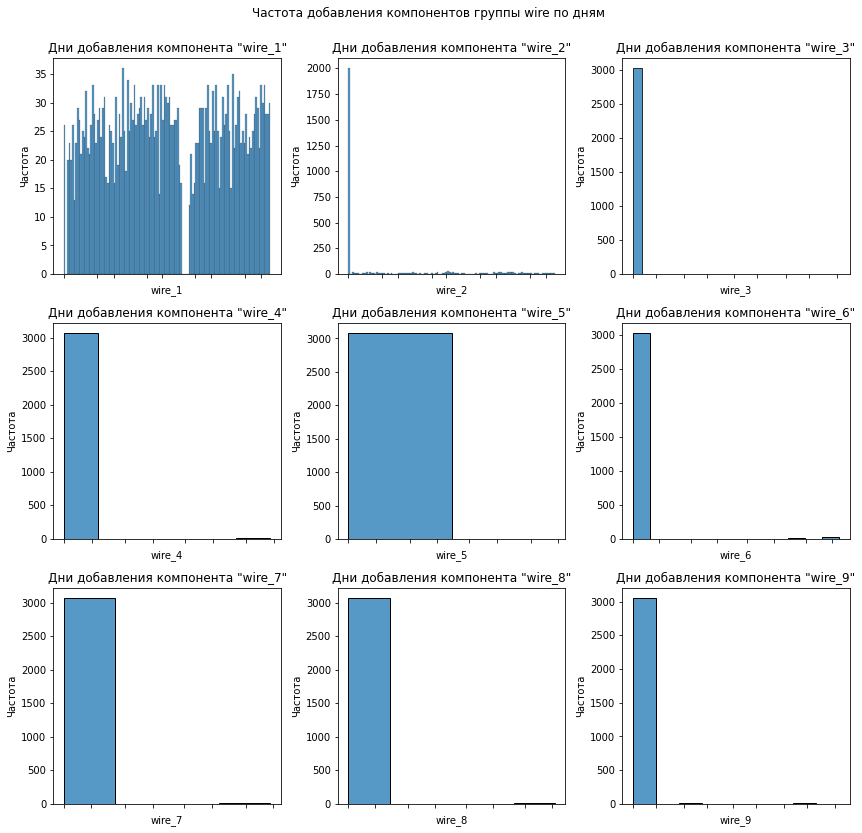

In [25]:
# and finally, let's examine the distributions of the added components wire and wire_time

wire_time_columns = wire_time_df.columns[1:]

fig, axes = plt.subplots(3, 3, figsize=(12, 12)) 
fig.suptitle('Frequency of adding wire group components by day', y=0.96)

for i, column in enumerate(wire_time_columns):
    
    bins = wire_time_df[column].apply(lambda x: x.date()).nunique()
    
    row = i // 3 
    col = i % 3  
    
    ax = axes[row, col]
    sns.histplot(wire_time_df[column], bins=bins, ax=ax)
    ax.set_title(f'Days of Adding Component "{column}"')
    ax.set_ylabel('Frequency')
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45) 

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

<h4 style="text-align: center;">Распределения добавок компонентов группы wire в массо-объемных показателях</h4>

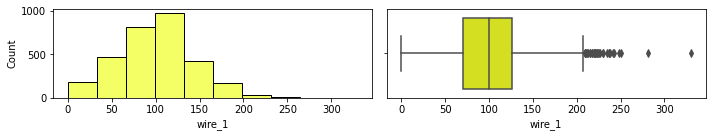

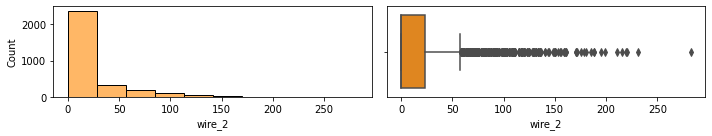

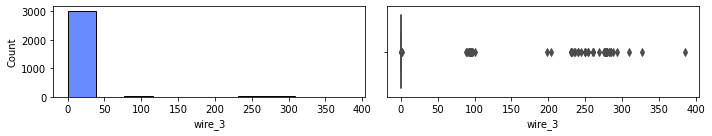

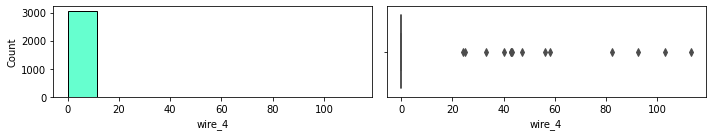

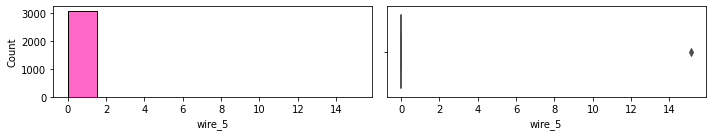

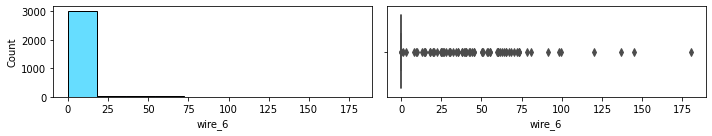

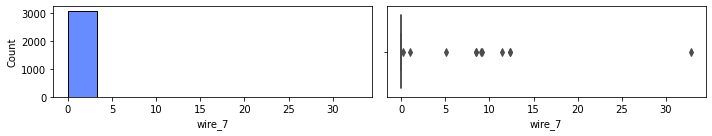

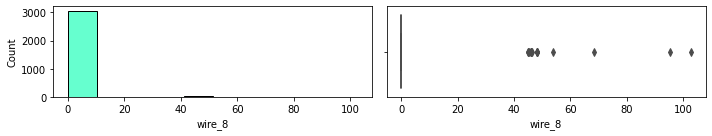

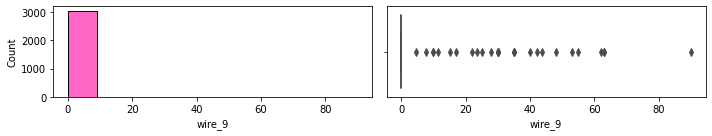

In [26]:
# let's take a look at the distribution of data on wire component additives
display(Markdown('<h4 style="text-align: center;">Distributions of wire group additives in mass-volume indicators</h4>'))

wire_columns = wire_df.columns[1:]
for column in wire_columns:
        hist_box(wire_df,column,bins=10,n=2)

From the graphs of the wire group additive data, it is evident that the most frequently used components are wire_1 and wire_2, which were added to almost every batch, while the other components (wire_3 to wire_9) were added less than 100 times in total throughout the entire period.

In terms of volume, the same components lead, while the volumes of other additives tend to show a more discrete distribution for specific batches, possibly due to the technological process (to eliminate specific defects or to impart specific properties at the request of customers).

No anomalies were detected; all outliers in the boxplots are due to the presence of zero usage of a component in a batch—against the backdrop of zero usage, all discrete applications appear as outliers.

**Conclusion**

In the data preprocessing phase, the following actions were performed:
- Dates were converted to the datetime format.
- A check for duplicates was conducted.
- Missing values in the data were filled with zero values, and empty dates were set to 2019-05-01.
- Batches in which the temperature fell significantly below 1500 degrees at any measurement were excluded.
- The table with temperatures for each batch was transformed to highlight the alloy temperature at the beginning and end of the process, and batches without an end temperature (the target variable) were excluded.
- Column names were converted to lowercase and spaces were replaced with underscores.

In data analysis:

- The graphs of power distribution revealed an anomaly in the negative direction, which was removed. With this in mind, no other anomalies were detected, and only a negligible number of outliers were recorded—these are likely due to the technological process and are not errors; their exclusion may negatively affect the generalization capability of the model. The distribution of measurements is fairly uniform, with some seasonality (for example, on weekends), and there is a gap of several days in the middle of the range, which may be attributed to technical work.

- From the graphs of the bulk group additive data, it is evident that the most frequently used components are bulk_12, bulk_14, and bulk_15, which were added to almost every batch, while the least common components are bulk_2, bulk_5, bulk_7, bulk_8, bulk_9, and bulk_13, which were added fewer than 100 times throughout the entire period. In terms of volume, the same components lead, while the volumes of other additives tend to show a more discrete distribution for specific batches, possibly due to the technological process (to eliminate specific defects or to impart specific properties at the request of customers). No anomalies were detected; all outliers in the boxplots are due to the presence of zero usage of a component in a batch.

- Gas blowing was not used in one-third of the cases; gas is most often applied in minimal volumes, and no anomalies or outliers were detected.

- The measurements of the incoming alloy temperature are distributed close to normal, with no significant outliers. In contrast, the output temperatures are distributed more closely to a T-distribution, showing a range toward higher values. This suggests the possibility of studying and reducing the output temperature (it is unlikely that an alloy with a higher temperature than what the technological process requires and the average temperature of most batches is needed at the output).

- From the graphs of the wire group additive data, it is evident that the most frequently used components are wire_1 and wire_2, which were added to almost every batch, while the other components (wire_3 to wire_9) were added less than 100 times in total throughout the entire period. Otherwise, the data behaves similarly to that of the bulk group components.

<a id='Data-Merging'></a>
## Data Merging
[Back to Contents](#Contents)

Taking into account the preprocessing performed, we will merge features from different tables into one and subsequently check the correlations between them and evaluate the possibilities of creating additional features. The merging of features will be based on the table with the target variable of the final temperature, as we need data on the batches for which there are values for the target variable (in other tables, there may be more batches than those with the target variable).

In [27]:
# we will add the calculated heating time in seconds and total power to the table with heating power data.
arc_df['время_нагрева'] = (arc_df['конец_нагрева_дугой']-arc_df['начало_нагрева_дугой']).dt.total_seconds()
arc_df['общая_мощность'] = (arc_df['активная_мощность']**2 + arc_df['реактивная_мощность']**2)**0.5
arc_df.head()

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность,время_нагрева,общая_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934


In [28]:
# we will group the data by batch and calculate the mean and sum for each column.
arc_df_grouped = arc_df.groupby('key').agg(
    активная_мощность_mean=('активная_мощность','mean'),
    активная_мощность_sum=('активная_мощность','sum'),
    реактивная_мощность_mean=('реактивная_мощность','mean'),
    реактивная_мощность_sum=('реактивная_мощность','sum'),
    время_нагрева_mean=('время_нагрева','mean'),
    время_нагрева_sum=('время_нагрева','sum'),
    общая_мощность_mean=('общая_мощность','mean'),
    общая_мощность_sum=('общая_мощность','sum')
)

arc_df_grouped.head()


,активная_мощность_mean,активная_мощность_sum,реактивная_мощность_mean,реактивная_мощность_sum,время_нагрева_mean,время_нагрева_sum,общая_мощность_mean,общая_мощность_sum
key,,,,,,,,
1,0.607346,3.036730,0.428564,2.142821,219.60,1098.0,0.743747,3.718736
2,0.534852,2.139408,0.363339,1.453357,202.75,811.0,0.647087,2.588349
3,0.812728,4.063641,0.587491,2.937457,131.00,655.0,1.003845,5.019223
4,0.676622,2.706489,0.514248,2.056992,185.25,741.0,0.850010,3.400038
5,0.563238,2.252950,0.421998,1.687991,217.25,869.0,0.704245,2.816980


In [29]:
# add the features to the main table.
data = pd.merge(temp_clean, arc_df_grouped, on='key', how='inner')

data.head()

,key,start_temp_time,start_temp,end_temp_time,end_temp,активная_мощность_mean,активная_мощность_sum,реактивная_мощность_mean,реактивная_мощность_sum,время_нагрева_mean,время_нагрева_sum,общая_мощность_mean,общая_мощность_sum
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,0.607346,3.036730,0.428564,2.142821,219.60,1098.0,0.743747,3.718736
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,0.534852,2.139408,0.363339,1.453357,202.75,811.0,0.647087,2.588349
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,0.812728,4.063641,0.587491,2.937457,131.00,655.0,1.003845,5.019223
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,0.676622,2.706489,0.514248,2.056992,185.25,741.0,0.850010,3.400038
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,0.563238,2.252950,0.421998,1.687991,217.25,869.0,0.704245,2.816980


In [30]:
# next, we will filter the batches where there were violations of the technological process during the addition of bulk group components.
# we will check that the time of adding any of the components was "within" the temperature measurement period.

# we will select from the bulk_time_df table only those keys that are present in temp_clean.
keys_to_check = temp_clean['key'].unique()
filtered_bulk_time_df = bulk_time_df[bulk_time_df['key'].isin(keys_to_check)].copy()

# checking the conditions for being within the temperature measurement period for the filtered keys
def check_time_conditions(row):
    key = row['key']
    start_time = temp_clean.loc[temp_clean['key'] == key, 'start_temp_time'].values[0]
    end_time = temp_clean.loc[temp_clean['key'] == key, 'end_temp_time'].values[0]
    
    for col in bulk_columns:
        bulk_time = row[col]
        # if the time is not equal to 2019-05-01, it must be between start_temp_time and end_temp_time
        if bulk_time != pd.Timestamp('2019-05-01'):
            if pd.isnull(bulk_time) or not (start_time <= bulk_time <= end_time):
                return False
    return True

# we will apply the function to the entire filtered table.
filtered_bulk_time_df['time_check'] = filtered_bulk_time_df.apply(check_time_conditions, axis=1)

# filter out the rows where the condition is not met.
invalid_rows = filtered_bulk_time_df[filtered_bulk_time_df['time_check'] == False]

# and remove the batches from filtered_bulk_time_df and bulk_df that are present in invalid_rows.
filtered_bulk_time_df = filtered_bulk_time_df[~filtered_bulk_time_df.index.isin(invalid_rows.index)]
bulk_df = bulk_df[~bulk_df.index.isin(invalid_rows.index)]

# remove the 'time_check' column
filtered_bulk_time_df = filtered_bulk_time_df.drop(columns=['time_check'])

In [31]:
invalid_rows

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,time_check
261,279,2019-05-01,2019-05-01,2019-05-01,2019-05-01,2019-05-01,2019-05-14 10:13:37,2019-05-01,2019-05-01,2019-05-01,2019-05-01,2019-05-01,2019-05-01,2019-05-01,2019-05-01,2019-05-01,False


In [32]:
# add the bulk group features to the main table
data = pd.merge(data, bulk_df, on='key', how='inner')

display(data.shape)
data.head()

(2403, 28)

,key,start_temp_time,start_temp,end_temp_time,end_temp,активная_мощность_mean,активная_мощность_sum,реактивная_мощность_mean,реактивная_мощность_sum,время_нагрева_mean,время_нагрева_sum,общая_мощность_mean,общая_мощность_sum,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,0.607346,3.036730,0.428564,2.142821,219.60,1098.0,0.743747,3.718736,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,0.534852,2.139408,0.363339,1.453357,202.75,811.0,0.647087,2.588349,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,0.812728,4.063641,0.587491,2.937457,131.00,655.0,1.003845,5.019223,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,0.676622,2.706489,0.514248,2.056992,185.25,741.0,0.850010,3.400038,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,0.563238,2.252950,0.421998,1.687991,217.25,869.0,0.704245,2.816980,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [33]:
# next, we will add the data on the gas purging for each batch.
data = pd.merge(data, gas_df, on='key', how='inner')

In [34]:
# next, we will filter the batches where there were violations of the technological process during the addition of wire group components.
# we will check that the time of adding any of the components was "within" the temperature measurement period.

# we will select from the wire_time_df table only those keys that are present in temp_clean
keys_to_check = temp_clean['key'].unique()
filtered_wire_time_df = wire_time_df[wire_time_df['key'].isin(keys_to_check)].copy()

# checking the conditions for being within the temperature measurement period for the filtered keys
def check_time_conditions(row):
    key = row['key']
    start_time = temp_clean.loc[temp_clean['key'] == key, 'start_temp_time'].values[0]
    end_time = temp_clean.loc[temp_clean['key'] == key, 'end_temp_time'].values[0]
    
    for col in wire_columns:
        wire_time = row[col]
        # if the time is not equal to 2019-05-01, it must be between start_temp_time and end_temp_time
        if wire_time != pd.Timestamp('2019-05-01'):
            if pd.isnull(wire_time) or not (start_time <= wire_time <= end_time):
                return False
    return True

# we will apply the function to the entire filtered table
filtered_wire_time_df['time_check'] = filtered_wire_time_df.apply(check_time_conditions, axis=1)

# фильтруем строки, где не выполнено условие
invalid_rows = filtered_wire_time_df[filtered_wire_time_df['time_check'] == False]

# and remove the batches from filtered_wire_time_df and wire_df that are in invalid_rows
filtered_wire_time_df = filtered_wire_time_df[~filtered_wire_time_df.index.isin(invalid_rows.index)]
wire_df = wire_df[~wire_df.index.isin(invalid_rows.index)]

# we will remove the 'time_check' column
filtered_wire_time_df = filtered_wire_time_df.drop(columns=['time_check'])

In [35]:
display(invalid_rows)

wire_df.shape

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,time_check
256,279,2019-05-14 10:13:37,2019-05-01,2019-05-01,2019-05-01,2019-05-01,2019-05-01,2019-05-01,2019-05-01,2019-05-01,False


(3080, 10)

In [36]:
# add the features from the wire group to the main table
data = pd.merge(data, wire_df, on='key', how='inner')

display(data.shape,
        data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   key                       2325 non-null   object        
 1   start_temp_time           2325 non-null   datetime64[ns]
 2   start_temp                2325 non-null   float64       
 3   end_temp_time             2325 non-null   datetime64[ns]
 4   end_temp                  2325 non-null   float64       
 5   активная_мощность_mean    2325 non-null   float64       
 6   активная_мощность_sum     2325 non-null   float64       
 7   реактивная_мощность_mean  2325 non-null   float64       
 8   реактивная_мощность_sum   2325 non-null   float64       
 9   время_нагрева_mean        2325 non-null   float64       
 10  время_нагрева_sum         2325 non-null   float64       
 11  общая_мощность_mean       2325 non-null   float64       
 12  общая_мощность_sum  

(2325, 38)

None

**Conclusion**

As a result of merging features into a single table, we obtained 2,325 rows (batches) and 38 columns (37 input features). Next, we will need to preprocess the final table, analyze the data, and decide which features will be used in the model.

<a id='Analysis-of-the-merged-dataframe'></a> 
## Exploratory Data Analysis and Preprocessing of the Merged DataFrame  
[Back to Contents](#Back-to-Contents)

In [37]:
# remove the temperature measurement time data
data = data.drop(columns=['start_temp_time', 'end_temp_time'])

# fill missing values in the data with zeros
data.fillna(0,inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   key                       2325 non-null   int64  
 1   start_temp                2325 non-null   float64
 2   end_temp                  2325 non-null   float64
 3   активная_мощность_mean    2325 non-null   float64
 4   активная_мощность_sum     2325 non-null   float64
 5   реактивная_мощность_mean  2325 non-null   float64
 6   реактивная_мощность_sum   2325 non-null   float64
 7   время_нагрева_mean        2325 non-null   float64
 8   время_нагрева_sum         2325 non-null   float64
 9   общая_мощность_mean       2325 non-null   float64
 10  общая_мощность_sum        2325 non-null   float64
 11  bulk_1                    2325 non-null   float64
 12  bulk_2                    2325 non-null   float64
 13  bulk_3                    2325 non-null   float64
 14  bulk_4  

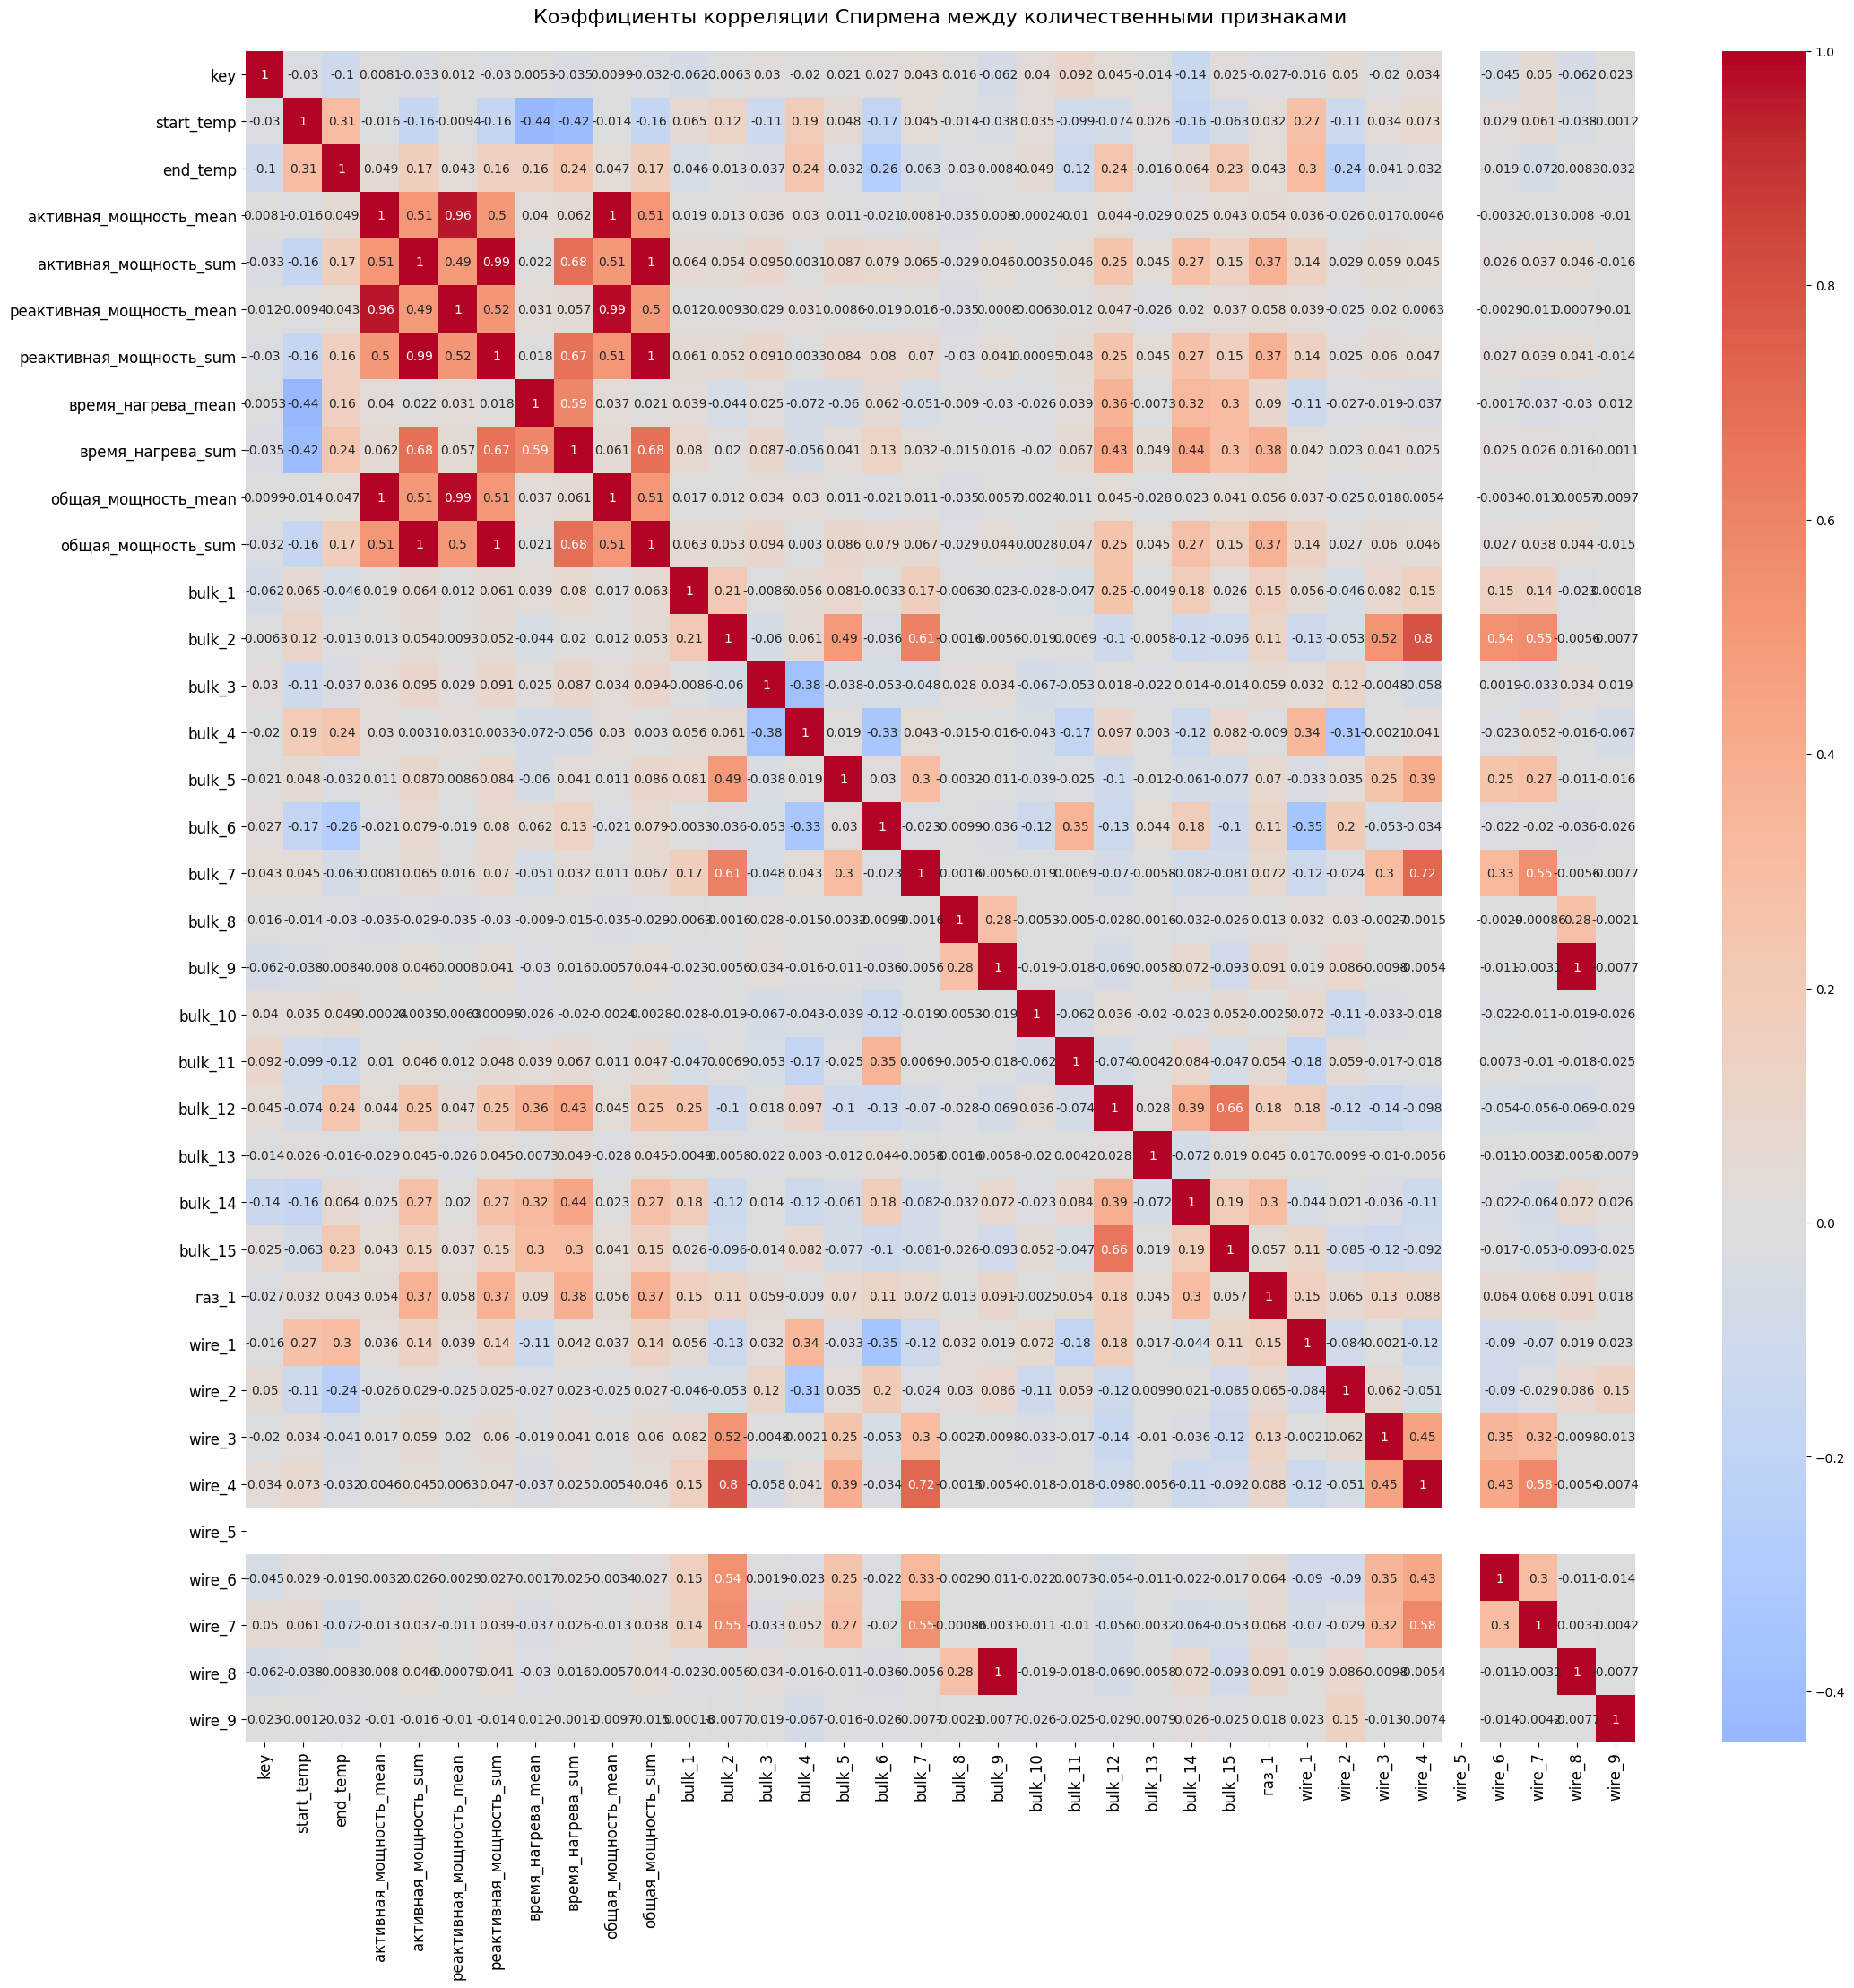

In [38]:
# let’s build a correlation matrix between all features since they are all quantitative
columns_num = data.columns
# since our data is not normally distributed, we’ll use Spearman’s rank correlation coefficient
plt.figure(figsize=(25,25), dpi= 100)
sns.heatmap(data[columns_num].corr(method='spearman'), 
                        xticklabels=data[columns_num].corr(method='spearman').columns, 
                        yticklabels=data[columns_num].corr(method='spearman').columns, 
                        cmap='coolwarm' , 
                        center=0, 
                        annot=True)

plt.title('Spearman correlation coefficients between quantitative features\n', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation='horizontal')
plt.show()

In [39]:
# check how many zero values are in the column wire_5
data[data['wire_5'] == 0]['key'].count()

2325

In [40]:
# remove multicollinear features, as well as the wire_5 feature since it is completely zero
data = data.drop(columns=['реактивная_мощность_mean','активная_мощность_mean','реактивная_мощность_sum','активная_мощность_sum','wire_5','wire_8'])

We will also look at the distribution plots of the new features since we have already done this for the others during the initial data analysis.

**Статистики и распределения для время_нагрева_mean:**

count    2325.000000
mean      172.090546
std        43.751270
min        57.000000
25%       141.000000
50%       169.500000
75%       198.750000
max       378.000000
Name: время_нагрева_mean, dtype: float64

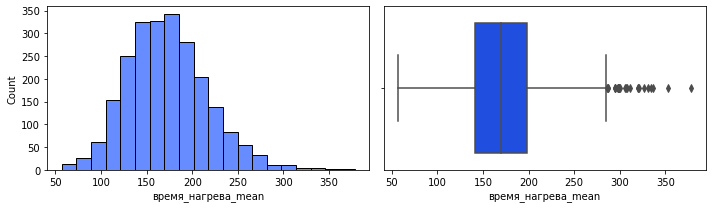

**Статистики и распределения для время_нагрева_sum:**

count    2325.000000
mean      807.988387
std       340.888430
min        57.000000
25%       581.000000
50%       778.000000
75%       993.000000
max      4189.000000
Name: время_нагрева_sum, dtype: float64

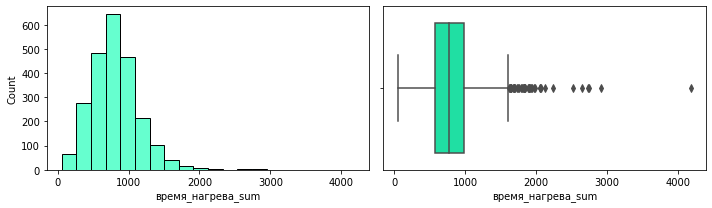

**Статистики и распределения для общая_мощность_mean:**

count    2325.000000
mean        0.825638
std         0.160377
min         0.331897
25%         0.714331
50%         0.818378
75%         0.921276
max         1.572238
Name: общая_мощность_mean, dtype: float64

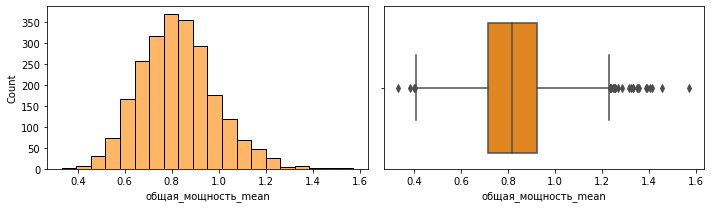

**Статистики и распределения для общая_мощность_sum:**

count    2325.000000
mean        3.885528
std         1.517546
min         0.331897
25%         2.844193
50%         3.769823
75%         4.769421
max        15.288271
Name: общая_мощность_sum, dtype: float64

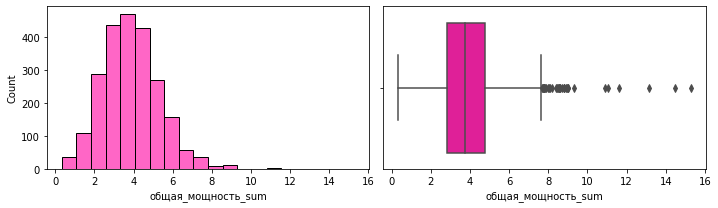

In [41]:
new_columns = ['время_нагрева_mean','время_нагрева_sum','общая_мощность_mean','общая_мощность_sum']

for column in new_columns:
    display(Markdown(f'**Statistics and distributions for {column}:**'))
    display(data[column].describe())
    hist_box(data,column,bins=20)

**Conclusion**

As a result of the merging, we encountered missing values for some features, and these batches were excluded as incomplete information.

The correlation table revealed several multicollinear features, as well as a zero feature, which were removed, along with the temperature measurement time values (which do not carry meaningful information but were useful for data filtering).

The target feature showed weak correlations with 7 factors at levels of 0.2-0.4, while the remaining features exhibited even weaker relationships. However, some features demonstrated a genuine correlation among themselves at levels of 0.3-0.5, which could assist in explaining the target feature, so we will retain all features.

The analysis of the new features indicated that they are approximately normally distributed and have some outliers, which may be related to the peculiarities of the technological process for different batches of alloy.

<a id='Model-Training'></a>  
## Data Preparation and Model Training  
[Back to Contents](#Back-to-Contents)

First, we will create the datasets for training and testing the models. Then, we will build pipelines for data preparation and model training based on the Linear Regression, Elastic Net, Random Forest Regressor, CatBoost, and a neural network using KerasRegressor algorithms.

In [42]:
# set the constants
RANDOM_STATE = 11024
TEST_SIZE = 0.25

In [43]:
# create the datasets for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['key','end_temp'], axis=1),
    data['end_temp'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)

In [44]:
# create a list of names for the quantitative features
num_columns = X_train.columns

# create a general pipeline for data preparation
pipe_final = Pipeline([
    ('preprocessor', ColumnTransformer(
        [
            ('num', StandardScaler(), num_columns)
        ], 
        remainder='passthrough'
    )),
    ('models', LinearRegression())
])


In [45]:
# create a neural network using KerasRegressor

def create_model(randome_state=RANDOM_STATE):
    tf.random.set_seed(randome_state)
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.1))
    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model


In [46]:
# set the hyperparameter sets for tuning
param_grid_1 = [
    
    # dictionary for the LinearRegression()
    {
        'models': [LinearRegression()]
    },

    # dictionary for the ElasticNet() model # regression with regularization
    {
         'models': [ElasticNet()],
         'models__alpha': [0.1, 1],
         'models__l1_ratio': [0.3, 0.5, 0.7]
    },

    # dictionary for the RandomForestRegressor() model
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(50, 151, 50),
        'models__max_depth': [15, 30],
        'models__min_samples_split': range(2, 7),
        'models__max_features': range(25, 35, 5),
    },

    # dictionary for the CatBoostRegressor()
    {
         'models': [CatBoostRegressor(verbose=False, 
                                      random_state=RANDOM_STATE)],
         'models__iterations': [150, 300],
         'models__learning_rate': [0.1, 1],
         'models__depth': [3, 7],
         'models__l2_leaf_reg': [3],
         'models__random_strength': [1]
    },

    # dictionary for the KerasRegressor()
    {
        'models': [KerasRegressor(model=create_model, verbose=2)],
        'models__epochs': [1000],
        'models__batch_size': [20]
    }
    
]

In [47]:
%%time

# full hyperparameter tuning using GridSearchCV with tqdm

param_grid_1_list = ParameterGrid(param_grid_1)  # parameters for tuning inside tqdm

# setting up tqdm
total_combinations = len(param_grid_1_list)
with tqdm(total=total_combinations) as pbar:
    best_score = 100
    best_params = None
    best_model = None
    results_list = []

    for params in param_grid_1_list:
        grid_search_1 = GridSearchCV(
            pipe_final,
            {k: [v] for k, v in params.items()},  # plug in a specific set of parameters
            cv=5,
            scoring='neg_mean_absolute_error',
            n_jobs=-1,
        )
        model_1 = grid_search_1.fit(X_train, y_train)

        # export the metric negMAE (negative MAE)
        best_score_neg_mae_1 = model_1.best_score_
        best_score_mae_1 = round(-best_score_neg_mae_1, 3)  # convert to positive mae

        # update the best metric (compare by minimum mae)
        if -best_score_neg_mae_1 < best_score: 
            best_score = -best_score_neg_mae_1  
            best_params = params  
            best_model = model_1  

        results_list.append(pd.DataFrame(model_1.cv_results_)) # accumulate parameter sets and metrics in a list
        pbar.update(1)  # update the tqdm progress bar

res = pd.concat(results_list, ignore_index=True)

# print the result
print(f'Лучший MAE: {best_score}')
print(f'Лучшие параметры модели: {best_params}')

  0%|          | 0/76 [00:00<?, ?it/s]

Epoch 1/1000
70/70 - 2s - 29ms/step - loss: 1581.6329
Epoch 2/1000
70/70 - 0s - 5ms/step - loss: 997.1130
Epoch 3/1000
70/70 - 0s - 4ms/step - loss: 377.8068
Epoch 4/1000
70/70 - 0s - 4ms/step - loss: 353.0226
Epoch 5/1000
70/70 - 0s - 4ms/step - loss: 339.9885
Epoch 6/1000
70/70 - 0s - 3ms/step - loss: 327.4057
Epoch 7/1000
70/70 - 0s - 3ms/step - loss: 322.0106
Epoch 8/1000
70/70 - 0s - 4ms/step - loss: 308.3147
Epoch 9/1000
70/70 - 0s - 4ms/step - loss: 323.5121
Epoch 10/1000
70/70 - 0s - 4ms/step - loss: 300.5716
Epoch 11/1000
70/70 - 0s - 4ms/step - loss: 303.1942
Epoch 12/1000
70/70 - 0s - 4ms/step - loss: 297.9263
Epoch 13/1000
70/70 - 0s - 4ms/step - loss: 289.3208
Epoch 14/1000
70/70 - 0s - 4ms/step - loss: 284.3400
Epoch 15/1000
70/70 - 0s - 3ms/step - loss: 291.3736
Epoch 16/1000
70/70 - 0s - 4ms/step - loss: 282.2972
Epoch 17/1000
70/70 - 0s - 4ms/step - loss: 283.4418
Epoch 18/1000
70/70 - 0s - 4ms/step - loss: 281.8445
Epoch 19/1000
70/70 - 0s - 4ms/step - loss: 277.3832


In [48]:
# look at the top-5 models
res=res.sort_values(by='mean_test_score', ascending=False)

res.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,param_models__alpha,param_models__l1_ratio,param_models__max_depth,param_models__max_features,param_models__min_samples_split,param_models__n_estimators,param_models__depth,param_models__iterations,param_models__l2_leaf_reg,param_models__learning_rate,param_models__random_strength,param_models__batch_size,param_models__epochs
69,0.941262,0.075411,0.005277,0.000181,<catboost.core.CatBoostRegressor object at 0x7fcecf2692e0>,"{'models': <catboost.core.CatBoostRegressor object at 0x7fcecf2692e0>, 'models__depth': 3, 'models__iterations': 300, 'models__l2_leaf_reg': 3, 'models__learning_rate': 0.1, 'models__random_strength': 1}",-6.354205,-6.050784,-6.735305,-5.968078,-6.094557,-6.240586,0.279022,1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,300.0,3.0,0.1,1.0,NaN,NaN
71,1.484750,0.055992,0.005849,0.000683,<catboost.core.CatBoostRegressor object at 0x7fcecf2692e0>,"{'models': <catboost.core.CatBoostRegressor object at 0x7fcecf2692e0>, 'models__depth': 7, 'models__iterations': 150, 'models__l2_leaf_reg': 3, 'models__learning_rate': 0.1, 'models__random_strength': 1}",-6.338500,-6.044672,-6.771549,-5.983117,-6.130690,-6.253706,0.285446,1,NaN,NaN,NaN,NaN,NaN,NaN,7.0,150.0,3.0,0.1,1.0,NaN,NaN
67,0.939162,0.283426,0.006157,0.001256,<catboost.core.CatBoostRegressor object at 0x7fcecf2692e0>,"{'models': <catboost.core.CatBoostRegressor object at 0x7fcecf2692e0>, 'models__depth': 3, 'models__iterations': 150, 'models__l2_leaf_reg': 3, 'models__learning_rate': 0.1, 'models__random_strength': 1}",-6.399509,-6.125639,-6.714295,-6.034156,-6.052119,-6.265144,0.259995,1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,150.0,3.0,0.1,1.0,NaN,NaN
73,2.733145,0.396379,0.005392,0.000122,<catboost.core.CatBoostRegressor object at 0x7fcecf2692e0>,"{'models': <catboost.core.CatBoostRegressor object at 0x7fcecf2692e0>, 'models__depth': 7, 'models__iterations': 300, 'models__l2_leaf_reg': 3, 'models__learning_rate': 0.1, 'models__random_strength': 1}",-6.358348,-6.098584,-6.819747,-5.939465,-6.248168,-6.292862,0.298840,1,NaN,NaN,NaN,NaN,NaN,NaN,7.0,300.0,3.0,0.1,1.0,NaN,NaN
66,1.994761,0.025974,0.021093,0.001359,RandomForestRegressor(random_state=11024),"{'models': RandomForestRegressor(random_state=11024), 'models__max_depth': 30, 'models__max_features': 30, 'models__min_samples_split': 6, 'models__n_estimators': 150}",-6.348855,-6.209167,-6.787399,-6.263848,-5.974377,-6.316729,0.266133,1,NaN,NaN,30.0,30.0,6.0,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Conclusion**

As a result of training several models during cross-validation, the best result was achieved with the CatBoost model, which showed an MAE metric of 6.24 degrees. Additionally, the top-5 models were almost entirely composed of CatBoost models with different hyperparameters, with Random Forest rounding out the top-5, indicating that decision trees are clearly the most accurate for temperature prediction tasks.

Thus, we can conclude that for solving this problem, the most optimal approach will be to use the CatBoost model with the hyperparameters (‘models__depth’: 3, ‘models__iterations’: 300, ‘models__l2_leaf_reg’: 3, ‘models__learning_rate’: 0.1, ‘models__random_strength’: 1), trained on all available data.

<a id='Analysis-and-Testing-of-the-Final-Model'></a>  
## Analysis and Testing of the Final Model  
[Back to Contents](#Back-to-Contents)

In [49]:
# check the performance of the selected model on the test set
y_test_pred1 = best_model.predict(X_test)
print(f'MAE metric on the test set: {round(mean_absolute_error(y_test, y_test_pred1),3)}')

Метрика MAE на тестовой выборке: 6.219


On the test set, the model achieved a MAE metric of 6.21, which meets the required threshold of no more than 6.8.
We will also examine the influence of individual features and analyze the residuals of the model’s predictions.

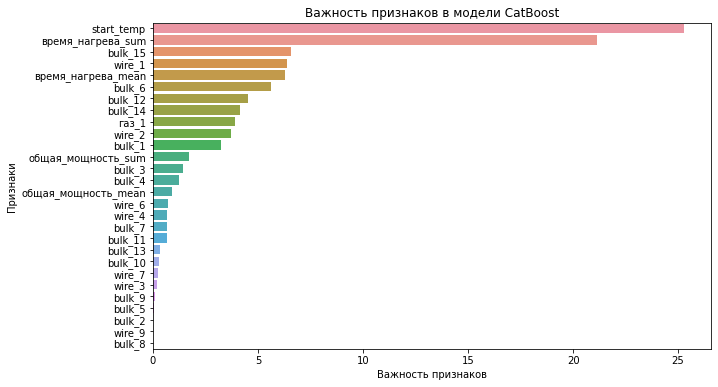

In [53]:
# look at feature importance in the CatBoost model
feature_importances = best_model.best_estimator_.named_steps['models'].get_feature_importance()
#feature_names = best_model.best_estimator_.named_steps['models'].feature_names_

# assemble into a DataFrame and sort in descending order
feature_importance_df = pd.DataFrame({
    'feature': num_columns,
    'importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

#display(feature_importance_df)

# visualize feature importance using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.xlabel("Feature Importance”)
plt.ylabel(“Features”)
plt.title(“Feature Importance in the CatBoost Model”)
plt.show()

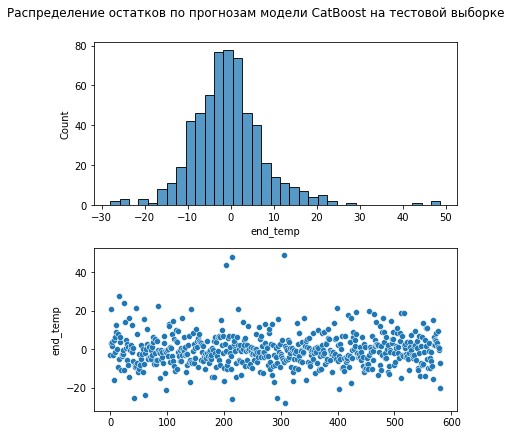

In [51]:
# look at the residuals of the model
fig, axes = plt.subplots(2,1,figsize=(6, 6))
fig.suptitle('Distribution of residuals for the CatBoost model predictions on the test set', y=1)

ost = y_test - y_test_pred1
ax = axes[0]
sns.histplot(data=ost, ax=ax)

ax = axes[1]
sns.scatterplot(x=range(len(y_test_pred1)), y=y_test - y_test_pred1,ax=ax);

plt.tight_layout();
plt.show();

The feature importance analysis highlighted the contribution of input temperature (25%) and heating time (21%), which is quite expected. the other features are less significant, while the addition of components bulk2, 5, 8, and wire_9 has near-zero significance in the temperature forecast.

The residuals analysis showed that they are distributed approximately normally, with only a few outliers. the residuals scatter plot indicates a uniform distribution around 0, suggesting that there are likely no patterns left unexplained by the model, which further confirms the model’s quality.

<a id='Overall-Conclusion'></a>  
## Overall Conclusion  
[Back to Contents](#Back-to-Contents)

Within the framework of this project, data describing the technical process of steel alloy processing were obtained and presented in 7 tables, including data on temperature measurements, the addition of bulk and wire group components, heater power, and the volume of gas blowing of the alloy.
After **loading the data**, we immediately noted the following features:

- there are quite a few missing values in the data, likely because some materials were intentionally not added during the metal processing of certain batches; therefore, it is better to fill them with zeros;
- the data types for timestamps are incorrectly specified and need to be corrected;
- duplicates need to be checked and excluded;
- the target feature has about 15% missing values, and the data related to these batches should be excluded since if we do not have temperature data for a batch, there is no point in using the input features for that batch;
- it is also necessary to check the features obtained after the temperature measurement, as they are useless for preliminary forecasting (if any elements are added after the temperature measurement);
- it is important to check the data for outliers and anomalies, as well as to examine the distribution of feature values;
- the column names in the tables are clear but inconvenient for use, so they need to be adjusted to meet PEP requirements.

During the **data preprocessing**, the following actions were performed in accordance with the above recommendations:

- dates were converted to datetime type,
- no duplicates were found,
- batches where the temperature significantly dropped below 1500 degrees in any measurement were excluded (the physical melting temperature of iron is 1538, but considering the measurement error, we set a threshold of less than 1500), indicating that the alloy structure underwent critical changes,
- the table with temperatures for each batch was processed to extract the temperature of the alloy at the beginning and end of the stage, and batches without a final temperature (the target feature) were excluded,
- in the columns with data on the addition of bulk and wire additives, all missing values were replaced with 0, and date/time values were set to 2019-05-01 (close to the start date of the experiment),
- column names were converted to lowercase and spaces were replaced with underscores.

**Exploratory analysis** revealed that:

- according to the <u>heating power distribution graphs</u>, there are no anomalies (considering the single removed incorrect value), and there is a minor number of outliers, which are likely due to the technological process and are not errors; their exclusion could negatively impact the model’s generalization ability.
- the distribution of the power measurements is fairly uniform, with some seasonality (for example, on weekends), and there is a gap of several days in the middle of the range, which may be due to technical work.
- based on the graphs of the <u>bulk component addition data</u>, it is clear that the most essential components are bulk_12, bulk_14, bulk_15, which were added to almost every batch, while the least frequently used are bulk_2, bulk_5, bulk_7, bulk_8, bulk_9, bulk_13, which were added less than 100 times throughout the entire period.
- in terms of volume, the same components lead, while the volumes of other components added have a more point-like distribution for specific batches, which may be due to the technological process (to eliminate specific defects or to give specific properties based on customer requests).
- no anomalies were identified; all outliers in the boxplots are due to the presence of zero usage of a component in a batch—against the backdrop of zero usage, all point applications appear as outliers.
- <u>gas blowing</u> was not used in a third of the cases, and gas is most often applied in minimal volumes.
- the <u>temperature measurements</u> of the incoming alloy are distributed close to normal, without significant outliers, while the <u>outlet temperatures</u> are distributed closer to a t-distribution, showing a tendency towards higher values, indicating the possibility of studying and reducing outlet temperature (it is unlikely that a higher temperature alloy than what the technological process and the average temperature of most batches require is needed).
- the graphs of the <u>wire component addition</u> data show that the most essential components are wire_1, wire_2, which were added to almost every batch, while the other components wire_3-wire_9 were added less than 100 times in total throughout the period. otherwise, the data behaves similarly to the bulk component group.

Subsequently, **features were merged** into a single table, resulting in 2325 rows (batches) and 38 columns (37 input features). The **analysis of the merged dataframe** showed that some features had missing values, which were removed as incomplete information.
The correlation table identified several multicollinear features, as well as a zero feature (wire_5), which were removed, as well as the temperature measurement times (which do not carry any semantic load but were useful for filtering data—batches - where there were violations of the technological process during the addition of bulk and wire components, as the timing of component additions was not “within” the temperature measurement period).

The target feature revealed weak connections with 7 factors at the level of 0.2-0.4, while the relationships with other features were weaker. However, some features showed a real connection at the level of 0.3-0.5, which may help in explaining the target feature, so it was decided not to exclude features with weak dependencies.

The analysis of the new features showed that they are distributed approximately normally and have some outliers, which may be related to the specifics of the technological process for different batches of alloy.

For **preparing model training**, the data were split into training and test sets in a ratio of 75% and 25%, respectively, after which pipelines for scaling data and training models based on the algorithms LinearRegression, ElasticNet, RandomForestRegressor, CatBoost, and a neural network based on KerasRegressor were formed, and hyperparameter sets for each algorithm were fixed.

As a **result of training** several models **during cross-validation**, the best result was achieved with the **CatBoost model**, which showed an **MAE metric of 6.24 degrees**. Thus, it can be concluded that the most optimal approach for solving this problem is to use the CatBoost model with hyperparameters (‘models__depth’: 3, ‘models__iterations’: 300, ‘models__l2_leaf_reg’: 3, ‘models__learning_rate’: 0.1, ‘models__random_strength’: 1), trained on all available data.
**This model** was selected for testing **on the test set**, where it **showed an MAE metric of 6.22 degrees**, which meets the required threshold of no more than 6.8 degrees.

The **analysis of feature importance** highlighted the contributions of input temperature (25%) and heating time (21%), which is quite expected. The other features are less significant, and the addition of bulk2, 5, 8, and wire_9 has near-zero significance in predicting temperature. Thus, to control/reduce outlet temperature, attention should be paid specifically to these features.

The **analysis of residuals** showed that they are distributed more closely to normal, with only a few outliers. The residuals scatter plot shows a uniform distribution around 0, suggesting that there are likely no unexplained patterns by the model, further confirming the model’s quality.